[View in Colaboratory](https://colab.research.google.com/github/sl2820/Deep_Learning_Study/blob/master/CNN_with_TF_Slim.ipynb)

### CNN MODEL wtih TF-Slim

# CNN Model with TF-Slim

In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy import ndimage
from six.moves import urllib
import tensorflow.contrib.slim as slim
import gzip
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
print ("Current TF Version [%s]" % (tf.__version__))
print ("Package Loaded")

Current TF Version [1.11.0-rc2]
Package Loaded


In [0]:
###
#def CNN (inputs, _is_training=True):
 # x = tf.reshape(inputs, [-1,28,28,1])
  #batch_norm_params = {'is_training': _is_training, 'decay': 0.9, 'updates_collections': None}
  #net = slim.conv2d(x, 32, [5,5], padding='SAME'
  #                 , activation_fn = tf.nn.relu
  #                 , weights_initializer = tf.truncated_normal_initializer(stddev = 0.01)
  #                 , normalizer_fn = slim.batch_norm
  #                 , normalizer_params = batch_norm_params
  #                 , scope = 'conv1') # adding bias, normalizing and everything is done right away.
  #net = slim.max_pool2d(net, [2,2], scope = 'pool1')
  #net = slim.conv2d(net, 64, [5,5], scope = 'conv2')
  #net = slim.max_pool2d(net, [2,2], scope = 'pool2')
  #net = slim.flatten(net, scope = 'flatten3')
  #net = slim.fully_connected(net, 1024
  #                          , activation_fn = tf.nn.relu
  #                          , weights_initializer = tf.truncated_normal_initializer(stddev = 0.01)
  #                          , normalizer_fn = slim.batch_norm
  #                          , normalizer_params = batch_norm_params
  #                          , scope = 'fc4')
  #net = slim.dropout(net, keep_prob = 0.7, is_training=_is_training, scope = 'dropout4')
  #out = slim.fully_connected(net, 10, activation_fn = None, normalizer_fn = None, scope = 'fco')
  #return out
###

### Handling MNIST

In [0]:
# Data URL
SOURCE_URL = "http://yann.lecun.com/exdb/mnist/"
DATA_DIRECTORY = "data"
# Parameters for MNIST
IMAGE_SIZE = 28
NUM_CHANNELS = 1
PIXEL_DEPTH = 255
NUM_LABELS = 10
VALIDATION_SIZE = 5000 # Size of the validation set

# Download MNIST data, if necessary
def maybe_download(filename):
  if not tf.gfile.Exists(DATA_DIRECTORY):
    tf.gfile.MakeDirs(DATA_DIRECTORY)
  filepath = os.path.join(DATA_DIRECTORY, filename)
  if not tf.gfile.Exists(filepath):
    filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
    with tf.gfile.GFile(filepath) as f:
      size = f.size()
    print ("Successfully downloaded ", filename, size, ' bytes.')
  return filepath

# Extract the images
def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_SIZE * IMAGE_SIZE * num_images * NUM_CHANNELS)
        data = numpy.frombuffer(buf, dtype=numpy.uint8).astype(numpy.float32)
        data = (data - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
        data = data.reshape(num_images, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)
        data = numpy.reshape(data, [num_images, -1])
    return data

# Extract the Labels
def extract_labels(filename, num_images):
  with gzip.open(filename) as bytestream:
    bytestream.read(8)
    buf = bytestream.read(1*num_images)
    labels = np.frombuffer(buf, dtype = np.uint8).astype(np.int64)
    num_labels_data = len(labels)
    one_hot_encoding = np.zeros((num_labels_data, NUM_LABELS))
    one_hot_encoding[np.arange(num_labels_data), labels]=1
    one_hot_encoding = np.reshape(one_hot_encoding, [-1, NUM_LABELS])
  return one_hot_encoding

# Augment training data
def expend_training_data(images, labels):

    expanded_images = []
    expanded_labels = []

    j = 0 # counter
    for x, y in zip(images, labels):
        j = j+1
        if j%100==0:
            print ('expanding data : %03d / %03d' % (j,numpy.size(images,0)))

        # register original data
        expanded_images.append(x)
        expanded_labels.append(y)

        # get a value for the background
        # zero is the expected value, but median() is used to estimate background's value 
        bg_value = numpy.median(x) # this is regarded as background's value        
        image = numpy.reshape(x, (-1, 28))

        for i in range(4):
            # rotate the image with random degree
            angle = numpy.random.randint(-15,15,1)
            new_img = ndimage.rotate(image,angle,reshape=False, cval=bg_value)

            # shift the image with random distance
            shift = numpy.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img,shift, cval=bg_value)

            # register new training data
            expanded_images.append(numpy.reshape(new_img_, 784))
            expanded_labels.append(y)

    # images and labels are concatenated for random-shuffle at each epoch
    # notice that pair of image and label should not be broken
    expanded_train_total_data = numpy.concatenate((expanded_images, expanded_labels), axis=1)
    numpy.random.shuffle(expanded_train_total_data)

    return expanded_train_total_data

# Prepare MNISt data
def prepare_MNIST_data(use_data_augmentation=True):
    # Get the data.
    train_data_filename = maybe_download('train-images-idx3-ubyte.gz')
    train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz')
    test_data_filename = maybe_download('t10k-images-idx3-ubyte.gz')
    test_labels_filename = maybe_download('t10k-labels-idx1-ubyte.gz')

    # Extract it into numpy arrays.
    train_data = extract_data(train_data_filename, 60000)
    train_labels = extract_labels(train_labels_filename, 60000)
    test_data = extract_data(test_data_filename, 10000)
    test_labels = extract_labels(test_labels_filename, 10000)

    # Generate a validation set.
    validation_data = train_data[:VALIDATION_SIZE, :]
    validation_labels = train_labels[:VALIDATION_SIZE,:]
    train_data = train_data[VALIDATION_SIZE:, :]
    train_labels = train_labels[VALIDATION_SIZE:,:]

    # Concatenate train_data & train_labels for random shuffle
    if use_data_augmentation:
        train_total_data = expend_training_data(train_data, train_labels)
    else:
        train_total_data = numpy.concatenate((train_data, train_labels), axis=1)

    train_size = train_total_data.shape[0]

    return train_total_data, train_size, validation_data, validation_labels, test_data, test_labels

#### From github.com/Hwalsuklee/tensorflow-mnist-cnn


### For Our Model

#### Load MNIST


In [4]:
mnist = input_data.read_data_sets('data/', one_hot = True)
trainimg = mnist.train.images
trainlabel = mnist.train.labels
valimg = mnist.validation.images
vallabel = mnist.validation.labels
testimg = mnist.test.images
testlabel = mnist.test.labels
print ("MNIST Ready")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
MN

### Define Model

In [5]:
n_input = 784
n_classes = 10
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
is_training = tf.placeholder(tf.bool)

def lrelu(x, leak=0.2, name='lrelu'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

def CNN(inputs, is_training=True):
    x = tf.reshape(inputs, [-1, 28, 28, 1])
    batch_norm_params = {'is_training': is_training
                         , 'decay':0.9
                         , 'updates_collections':None}
    init_func = tf.truncated_normal_initializer(stddev=0.01)
    net = slim.conv2d(x, 32, [5, 5], padding='SAME'
                                , activation_fn = lrelu
                                , weights_initializer = init_func
                                , normalizer_fn = slim.batch_norm
                                , normalizer_params = batch_norm_params
                                , scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pooll')
    net = slim.conv2d(x, 64, [5, 5], padding='SAME'
                                , activation_fn = lrelu
                                , weights_initializer = init_func
                                , normalizer_fn = slim.batch_norm
                                , normalizer_params = batch_norm_params
                                , scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, 1024
                                , activation_fn = lrelu
                                , weights_initializer = init_func
                                , normalizer_fn = slim.batch_norm
                                , normalizer_params = batch_norm_params
                                , scope='fc4')
    net = slim.dropout(net, keep_prob=0.7, is_training=is_training, scope='dr')
    out = slim.fully_connected(net, n_classes, activation_fn=None, normalizer_fn=None, scope='foo')
    return out
print ("NETWORK READY")

NETWORK READY


### Define Graph

In [6]:
# PREDICTION
pred = CNN(x, is_training)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print ("FUNCTION READY")


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

FUNCTION READY


### Check Variables

In [8]:
print("================== Trainable Variables=====================")
t_weights = tf.trainable_variables()
var_names_list = [v.name for v in tf.trainable_variables()]
for i in range (len(t_weights)):
  wval = sess.run(t_weights[i])
  print ("[%d/%d] [%s] / SHAPE IS %s"
        % (i, len(t_weights), var_names_list[i], wval.shape,))

================== Trainable Variables=====================
[0/8] [conv1/weights:0] / SHAPE IS (5, 5, 1, 32)
[1/8] [conv1/BatchNorm/beta:0] / SHAPE IS (32,)
[2/8] [conv2/weights:0] / SHAPE IS (5, 5, 1, 64)
[3/8] [conv2/BatchNorm/beta:0] / SHAPE IS (64,)
[4/8] [fc4/weights:0] / SHAPE IS (12544, 1024)
[5/8] [fc4/BatchNorm/beta:0] / SHAPE IS (1024,)
[6/8] [foo/weights:0] / SHAPE IS (1024, 10)
[7/8] [foo/biases:0] / SHAPE IS (10,)


### Saver

In [9]:
savedir = 'nets/cnn_mnist_modern'
saver = tf.train.Saver(max_to_keep = 100)
save_step = 4
if not os.path.exists(savedir):
  os.makedirs(savedir)
print ("Saver Ready")

Saver Ready


### Augmentation of DATA

In [0]:
def augment_img(xs):
  out = np.copy(xs)
  xs_r = np.reshape(xs, [-1,28,28])
  for i in range (xs_r.shape[0]):
    xs_img = xs_r[i, :, :]
    bg_value = 0
    # Rotate
    angle = np.random.randint(-15,15,1).astype(float)
    xs_img = ndimage.rotate(xs_img, angle, reshape=False, cval = bg_value)
    #Zoom
    rg = 0.1
    zoom_factor = np.random.uniform(1.,1.+rg)
    h, w = xs_img.shape[:2]
    zh = int(np.round(zoom_factor * h))
    zw = int(np.round(zoom_factor * w))
    top = (zh-h)//2
    left = (zw-w)//2
    zoom_tuple = (zoom_factor,) *2 + (1,) * (xs_img.ndim-2)
    temp = ndimage.zoom(xs_img[top:top+zh, left: left+zw], zoom_tuple)
    trim_top = ((temp.shape[0]-h)//2)
    trim_left = ((temp.shape[1]-w)//2)
    xs_img = temp[trim_top:trim_top+h, trim_left: trim_left+w]
    #Shift
    shift = np.random.randint(-3,3,2)
    xs_img = ndimage.shift(xs_img, shift, cval=bg_value)
    # Reshape
    xs_v = np.reshape(xs_img, [1,-1])
    out [i, : ] = xs_v
  return out
    

### Test Augmentation

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


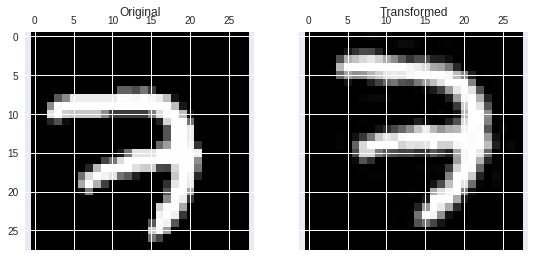

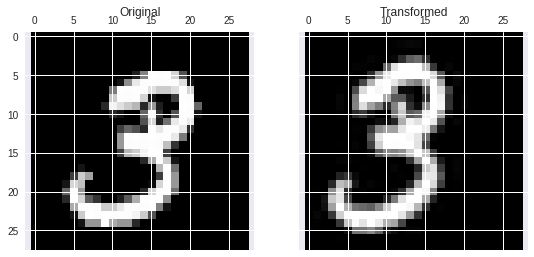

In [14]:
naug = 2
batch_xs = trainimg[:naug, :]
xs2 = augment_img(batch_xs)
for i in range (naug):
  x1 = batch_xs[i,:].reshape([28,28])
  x2 = xs2[i,:].reshape([28,28])
  f, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize = (9,4))
  ax1.matshow(x1, vmin=0, vmax = 1, cmap = plt.cm.gray)
  ax1.set_title("Original")
  ax2.matshow(x2, vmin=0, vmax = 1, cmap = plt.cm.gray)
  ax2.set_title("Transformed")
  plt.show()

### RUN

In [17]:
# pARAMETERS
training_epochs = 20
batch_size = 256
display_step = 4
val_acc = 0
val_acc_max = 0

#Optimize

for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = int(mnist.train.num_examples/batch_size)
  # Iteration
  for i in range (total_batch):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    #Augment Data
    if np.random.rand()<0.2:
      batch_x = augment_img(batch_x)
    feeds = {x: batch_x, y: batch_y, is_training: True}
    sess.run(optm, feed_dict=feeds)
    avg_cost += sess.run(cost, feed_dict = feeds)
  avg_cost = avg_cost / total_batch
  
  # Display
  if (epoch+1)%display_step ==0:
    print ("Epoch: %03d/%03d Cost: %.9f" % (epoch+1, training_epochs, avg_cost))
    randidx = np.random.permutation(trainimg.shape[0])[:500]
    feeds = {x:trainimg[randidx], y: trainlabel[randidx], is_training: False}
    train_acc = sess.run(accr, feed_dict = feeds)
    print ("Train Accuracy: %.5f" % (train_acc))
    feeds = {x: valimg, y: vallabel, is_training: False}
    val_acc = sess.run(accr, feed_dict = feeds)
    print("Validation Accuracy: %.5f" %(val_acc))
  
  # Save
  if (epoch+1)%save_step == 0:
    savename = savedir + "net-" +str(epoch)+".ckpt"
    saver.save(sess=sess, save_path = savename)
    print (" [%s] SAVED." % savename)
  
  # Maximum Validation Accuracy
  if val_acc>val_acc_max:
    val_acc_max = val_acc
    best_epoch = epoch
    print ("\x1b[31m BEST EPOCH UPDATED!! [%d] \x1b[0m" % (best_epoch))
print ("Optimization Finished")

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Epoch: 004/020 Cost: 0.051506778
Train Accuracy: 0.99400
Validation Accuracy: 0.98840
 [nets/cnn_mnist_modernnet-3.ckpt] SAVED.
 BEST EPOCH UPDATED!! [3] 
Epoch: 008/020 Cost: 0.032999793
Train Accuracy: 0.99800
Validation Accuracy: 0.98880
 [nets/cnn_mnist_modernnet-7.ckpt] SAVED.
 BEST EPOCH UPDATED!! [7] 
Epoch: 012/020 Cost: 0.024630571
Train Accuracy: 1.00000
Validation Accuracy: 0.99020
 [nets/cnn_mnist_modernnet-11.ckpt] SAVED.
 BEST EPOCH UPDATED!! [11] 
Epoch: 016/020 Cost: 0.022990071
Train Accuracy: 0.99800
Validation Accuracy: 0.99080
 [nets/cnn_mnist_modernnet-15.ckpt] SAVED.
 BEST EPOCH UPDATED!! [15] 
Epoch: 020/020 Cost: 0.022233902
Train Accuracy: 0.99800
Validation Accuracy: 0.98740
 [nets/cnn_mnist_modernnet-19.ckpt] SAVED.
Optimization Finished


### Compute Test Accuracy

In [27]:
best_epoch = 15
restorename = savedir + "net-" +str(best_epoch)+".ckpt"
print ("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
feeds = {x:testimg, y: testlabel, is_training: False}
test_acc = sess.run(accr, feed_dict = feeds)
print ("Test Accuracy: %.5f" % (test_acc))


Loading [nets/cnn_mnist_modernnet-15.ckpt]
INFO:tensorflow:Restoring parameters from nets/cnn_mnist_modernnet-15.ckpt
Test Accuracy: 0.98990
